# Proyecto usando datos de Kaggle

*    qué es kaggle y cómo descargar datos --> https://www.youtube.com/watch?v=NhHTWGIglRI
*    mirar notebooks --> https://www.kaggle.com/alexisbcook/titanic-tutorial
*    Repo en --> https://github.com/gonzalezgouveia/proyecto-titanic/
*    Video explicativo de este código YouTube --> https://www.youtube.com/watch?v=VkU-9Us6Rpw


### Pasos de este estudio
1. Carga de datos
1. Exploración
1. Procesamiento
1. Modelos
1. Evaluación
1. Predicción
1. Conclusión y próximos pasos

# Analisis de datos del titanic

## 1. Cargando datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# lectura de datos en Python
train = pd.read_csv('./../data/train.csv')
test = pd.read_csv('./../data/test.csv')

In [ ]:
train.head()

## 2. Explorando datos

In [ ]:
# que columnas tienen los datos?
train.columns

In [ ]:
# qué tamaño tienen los datos?
train.shape

In [ ]:
# hay valores nulos en los datos?
train.info()

In [ ]:
# como se distribuyen las variables numéricas
train.describe()

In [ ]:
# como se comportan las variables categóricas
train.describe(include=['O'])

## 2.1 EDA: Estudio de variable target

In [ ]:
train.groupby(['Survived']).count()['PassengerId']

In [ ]:
# target vs sex
train.groupby(['Survived','Sex']).count()['PassengerId']

In [ ]:
grouped_sex = train.groupby(['Survived','Sex']).count()['PassengerId']
print(grouped_sex)
(grouped_sex.unstack(level=0).plot.bar())
plt.show()

In [ ]:
# tarea hacer para otras variables

In [ ]:
# embarked vs pclass
print(train.groupby(['Pclass', 'Embarked'])
        .count()['PassengerId']
        .unstack(level=0)
        .plot.bar())

## 3.Procesamiento de datos

Empezamos seleccionando las variables que queremos trabajar que serían: 
* Survived
* Sex
* Age
* Pclass

In [ ]:
train[['Survived', 'Sex', 'Age', 'Pclass']].head(3)

Estudiamos los datos nulos

In [ ]:
train[['Survived', 'Sex', 'Age', 'Pclass']].info()

-----------------------
Tenemos que mejorar

*    Datos faltantes en Age `train['Age'].isna()`
*    La variable Sex aparece como object y queremos int o float para algoritmos
-----------------------

In [ ]:
# mirar como se distribuyen los nulos en edad
(train[train['Age'].isna()]
      .groupby(['Sex', 'Pclass'])
      .count()['PassengerId']
      .unstack(level=0))

In [ ]:
(train[train['Age'].isna()]
      .groupby(['SibSp', 'Parch'])
      .count()['PassengerId']
      .unstack(level=0))

De arriba se puede concluir que era gente que viajaba mayormente sola y la mayoría eran de 3era clase.

Esto nos da la idea de que se puede crear una variable que indique si la persona viajaba sola o acompañada.

La crearemos más adelante


In [ ]:
# calcular mediana de Age para imputar
train['Age'].median()

In [ ]:
# imputar valor para rellenar nulos
train['Age'] = train['Age'].fillna(28.0)
train[['Survived', 'Sex', 'Age', 'Pclass']].info()

Ya no tenemos nulos. Falta resolver lo de pasar Sex a int

In [ ]:
# map para label encoding
train['Sex'] = train['Sex'].map({'female': 1, 'male': 0}).astype(int)

Ahora tenemos la tabla preprocesada lista

In [ ]:
train[['Survived', 'Sex', 'Age', 'Pclass']].head(3)

## 3.1 Crear nuevas variables

In [ ]:
# crear nueva variable tipo flag "solo"
train['FlagSolo'] = np.where(
    (train['SibSp'] == 0) & (train['Parch'] == 0), 1, 0)

In [ ]:
grouped_flag = train.groupby(['Survived','FlagSolo']).count()['PassengerId']
print(grouped_flag)
(grouped_flag.unstack(level=0).plot.bar())
plt.show()

In [ ]:
train[['Survived', 'Sex', 'Age', 'Pclass', 'FlagSolo']].head(3)

Estos ya serían los datos con los que vamos a hacer modelos

In [ ]:
# variable dependiente
Y_train = train['Survived']

# preprocesamiento de variables independientes
features = ['Sex', 'Age', 'Pclass', 'FlagSolo']
X_train = train[features]

print(Y_train.shape, X_train.shape)

## 4. Modelos

Sin entrar en mucho detalle. Vamos a escoger dos modelos de prueba.
* regresión logistica
* arboles de decisión

In [ ]:
# entrenando modelo regresión logistica
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

In [ ]:
# entrenando modelo arboles de decisión
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

## 5. Evaluación

Aquí vamos a hacer una matriz de confusión y evaluar que tan bueno es cada modelo

In [ ]:
from sklearn.metrics import plot_confusion_matrix

def conf_mat_acc(modelo):
  disp = plot_confusion_matrix(modelo, X_train, Y_train,
                        cmap=plt.cm.Blues, values_format="d")
  true_pred = disp.confusion_matrix[0,0]+disp.confusion_matrix[1,1]
  total_data = np.sum(disp.confusion_matrix)
  accuracy = true_pred/total_data
  print('accuracy: ', np.round(accuracy, 2))
  plt.show()

In [ ]:
conf_mat_acc(logreg)

In [ ]:
conf_mat_acc(decision_tree)

## 5.1 Evaluación sobre el test set

Antes hicimos la matriz de confusión sobre el train set. Esto no es del todo correcto porque estamos utilizando como validación los datos que usamos de entrenamiento. Por lo tanto, la estimación del error sería sesgada y tendría poca capacidad de generalización a casos que no haya "visto" el modelo.

Por eso necesitamos utilizar el test set. Sin embargo, Kaggle no nos regresa el valor real del test set, para verificarlo tenemos que enviar nuestros resultados y mirar el score que pone kaggle esto lo veremos más adelante

In [ ]:
# ahora hay que preparar el test set para evaluación
print(test.head(3))
test.info()

In [ ]:
# preprocesando test set

# hacer map a Sex
test['Sex'] = test['Sex'].map({'female': 1, 'male': 0}).astype(int)

# rellenar Age
test['Age'] = test['Age'].fillna(28.0)

# Crear FlagSolo
test['FlagSolo'] = np.where(
    (test['SibSp'] == 0) & (test['Parch'] == 0), 1, 0)

In [ ]:
print(test.info())
test[features].head(3)

In [ ]:
# crear test set 
X_test = test[features]

print(X_test.shape)

In [ ]:
# prediccion de Survived en test set
Y_pred_log = logreg.predict(X_test)
Y_pred_tree = decision_tree.predict(X_test)
print(Y_pred_log[0:10])

Nota: Estas predicciones deberían ser ahora comparadas con el valor real para obtener una mejor estimación del error de predicción sobre el test set y poder escoger un modelo.

Sin embargo, como es una competicion de Kaggle este valor solo lo conoce la plataforma.

Vamos a exportar estos CSV y luego subirlos para ver cual tiene mejor rendimiento.


## 6. Predicción

In [ ]:
# prediciendo sobre el test set
print(Y_pred_log[0:20])
print(Y_pred_tree[0:20])

In [ ]:
# para descargar en ordenador
def download_output(y_pred, name):
  output = pd.DataFrame({'PassengerId': test.PassengerId, 
                         'Survived': y_pred})
  output.to_csv(name, index=False)

In [ ]:
download_output(Y_pred_log, 'rafa_pred_log.csv')
download_output(Y_pred_tree, 'rafa_pred_tree.csv')

Luego de hacer el envio a kaggle:

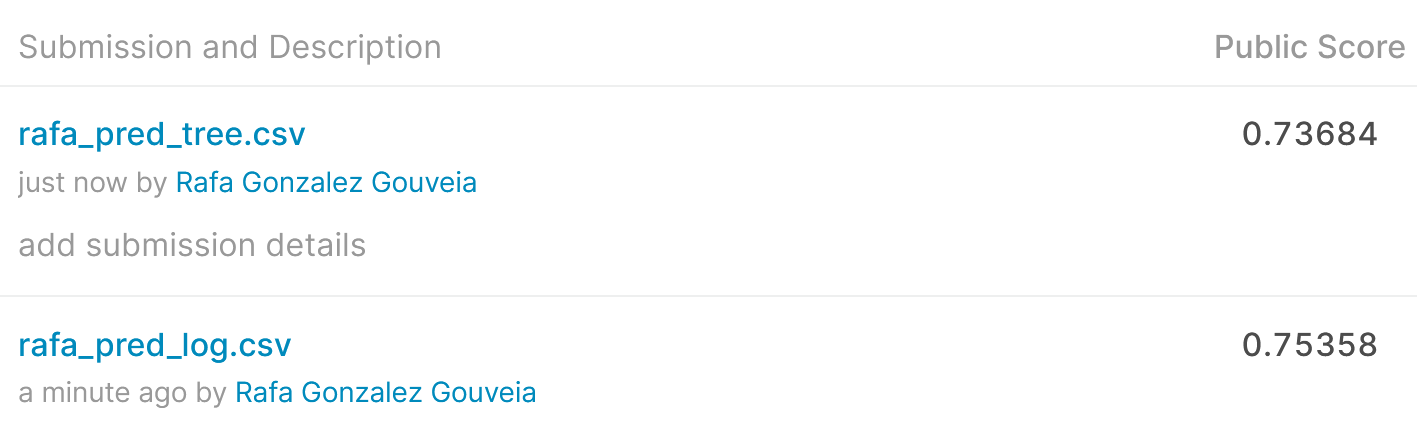

Con lo que muestra que en el test_set hay un mejor valor para accuracy que con train set.

Por esta razón, nos quedaríamos con el modelo de regresión logística. Porque generaliza mejor las predicciones para datos con los que no se ha entrenado el modelo.


# Conclusion

* importante del análisis exploratorio 
* creación de variables
* probar varios modelos
* calculo del error con el test_set
* vimos (casi) todo el proceso de ciencia de datos en un ejemplo

## próximos pasos

Ahora, lo que vendría sería desplegar este modelo a producción, hacer predicciones según lo necesite el usuario, hacer seguimiento y realizar el mantenimiento del despliegue.

Similar a como se describe superficialmente aquí https://cloud.google.com/ai-platform/docs/ml-solutions-overview

Sin embargo, estás etapas corresponden abarcan pasos relacionados a la ingeniería de software o devops que no serán cubiertos en este notebook.
